In [1]:
!pwd
import os
os.chdir('..')
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
from bilevel.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code/iclr_res


In [2]:
%%time
df_adult = pd.read_csv('./data_small/adult_reconstruction.csv')

A_t_age = pd.concat([df_adult['age'] <= 35,  # young
        (df_adult['age'] > 35) & (df_adult['age'] <= 50), # middle
        df_adult['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])

A_t_edu = pd.concat([df_adult['education-num'] <= 9, df_adult['education-num'] >= 10], axis = 1, 
                keys = ['HighSchool&less', 'College&more'])

A_t_sex = pd.concat([df_adult['sex'] == 'Male', df_adult['sex'] == 'Female'], axis = 1, keys = ['Male', 'Female'])

A_t_race = pd.concat([df_adult['race'] == 'White', df_adult['race'] == 'Asian-Pac-Islander',
                      df_adult['race'] == 'Amer-Indian-Eskimo', df_adult['race'] == 'Other',
                      df_adult['race'] == 'Black'], axis = 1, keys = ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'])
A_t_adult_groups = pd.concat([A_t_age, A_t_edu, A_t_sex, A_t_race], axis=1)
A_t_adult_groups['always_on'] = True
A_t_adult_groups *= 1
A_t_adult_groups

CPU times: user 60.5 ms, sys: 16.3 ms, total: 76.8 ms
Wall time: 75.5 ms


,young,middle,old,HighSchool&less,College&more,Male,Female,White,Asian-Pac-Islander,Amer-Indian-Eskimo,Other,Black,always_on
0,0,1,0,0,1,0,1,1,0,0,0,0,1
1,1,0,0,0,1,1,0,1,0,0,0,0,1
2,1,0,0,1,0,1,0,1,0,0,0,0,1
3,0,0,1,1,0,1,0,0,1,0,0,0,1
4,1,0,0,0,1,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49526,1,0,0,0,1,1,0,1,0,0,0,0,1
49527,0,1,0,0,1,1,0,0,1,0,0,0,1
49528,1,0,0,0,1,1,0,1,0,0,0,0,1
49529,1,0,0,0,1,0,1,1,0,0,0,0,1


In [3]:
added_indicators = ['young', 'middle', 'old', 'HighSchool&less', 'College&more']

In [4]:
numeric_all = ['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'education-num', 'income']
cat_feat =  ['workclass', 'marital-status', 'relationship', 'native-country', 'occupation', 'race', 'sex']

df_adult.drop(['education'], axis = 1, inplace=True)
df_adult_mm = numeric_scaler(df_adult, numeric_all)
df_adult_mm_oh = one_hot(df_adult_mm, cat_feat)
df_adult_mm_oh.drop(cat_feat, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_adult_mm_oh = df_adult_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_adult_mm_oh[added_indicators] = A_t_adult_groups[added_indicators]  # for a fair comparison for the baseline, we add these indicators to the dataframe too! 
df_adult_mm_oh.head()

,hours-per-week,age,capital-gain,capital-loss,education-num,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,race_Black,race_Other,race_White,sex_Female,sex_Male,young,middle,old,HighSchool&less,College&more
0,0.193878,0.315068,0.0,0.0,0.800000,0.490460,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0,1,0,0,1
1,0.397959,0.054795,0.0,0.0,0.600000,0.114053,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0,0,0,1
2,0.091837,0.000000,0.0,0.0,0.400000,0.024957,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0,0,1,0
3,0.500000,0.465753,0.0,0.0,0.533333,0.389320,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1,1,0
4,0.377551,0.150685,0.0,0.0,0.800000,0.413376,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0,0,0,1


In [5]:
np.all(df_adult_mm_oh[added_indicators + ['sex_Male', 'sex_Female', 'race_White', 'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other', 'race_Black']].to_numpy() == A_t_adult_groups.to_numpy()[:, :12])

True

In [6]:
%%time
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds
ds_obj = BuildGroupwise_diffseeds(df_adult_mm_oh, 'income', A_t_adult_groups)
ds_obj.build_all_seeds()
ds_obj.build_df_res()

100%|██████████| 49531/49531 [00:20<00:00, 2464.19it/s]


CPU times: user 30min 42s, sys: 1min, total: 31min 43s
Wall time: 3min 58s


In [4]:
# subgroups_list = [['young', 'middle', 'old'], ['HighSchool&less', 'College&more'], ['Male', 'Female'],
# ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'], ['always_on']]

# from bilevel.Groupwise_seedruns import plot_subgroups
# plot_subgroups(ds_obj, subgroups_list)

In [7]:
%%time
ds_obj.build_regret_curve()

CPU times: user 11min 20s, sys: 21.8 s, total: 11min 41s
Wall time: 1min 27s


In [5]:
# with open('adult_gw_ob.pkl', 'rb') as handle:
#     ds_obj = pickle.load(handle)

# adult_gw = load_ob('adult_gw_ob.pkl')

In [13]:
save_ob('adult_gw_expcloss_fair.pkl', ds_obj)

young 22792


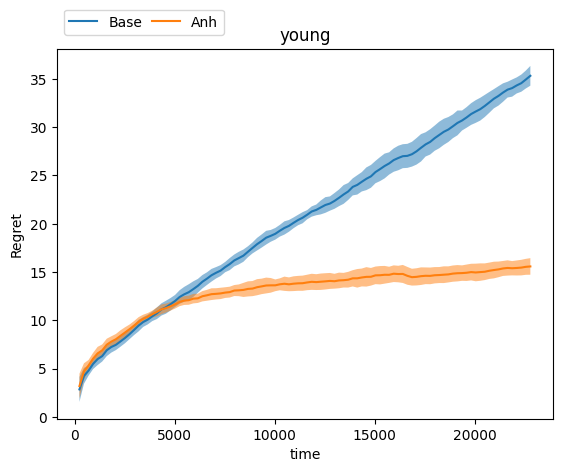

middle 16881


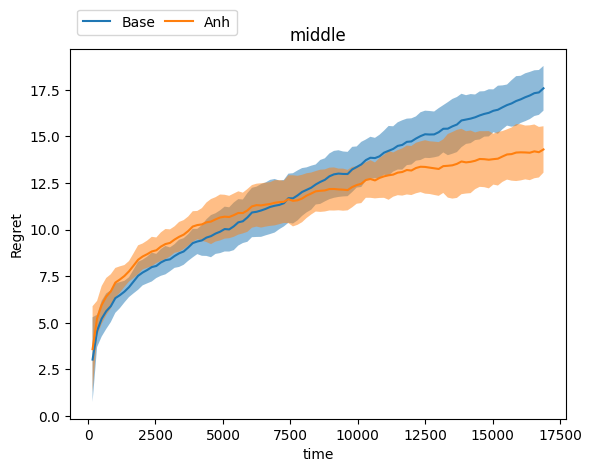

old 9858


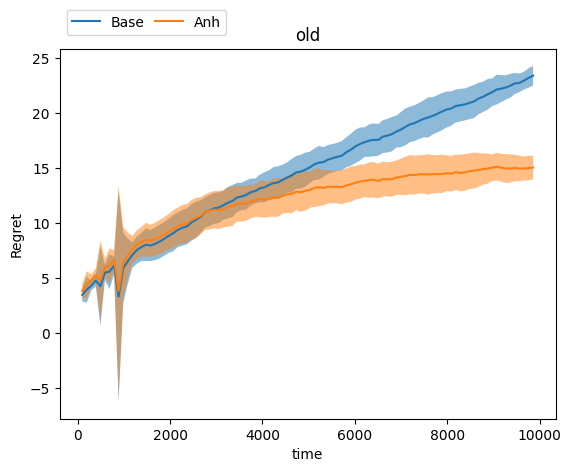

HighSchool&less 22584


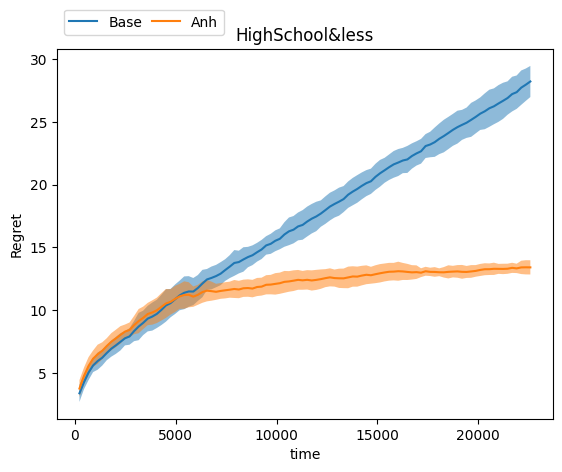

College&more 26947


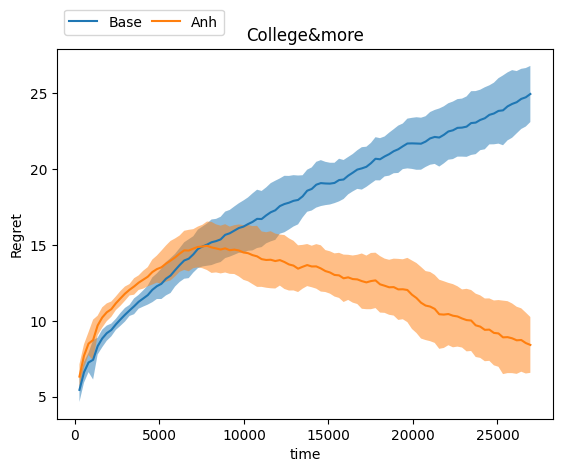

Male 33174


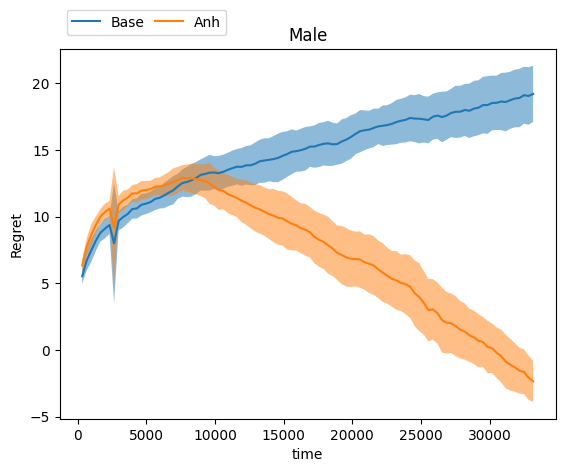

Female 16357


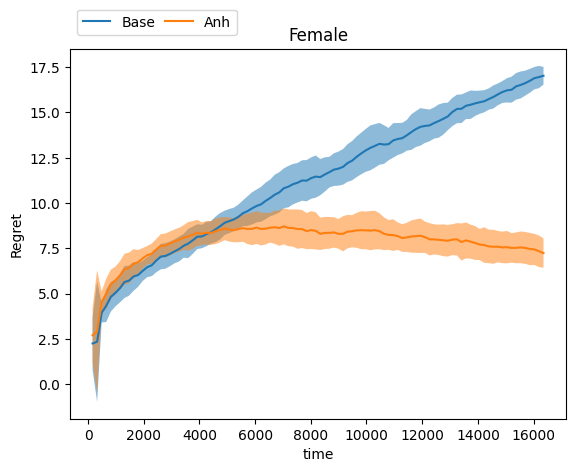

White 42441


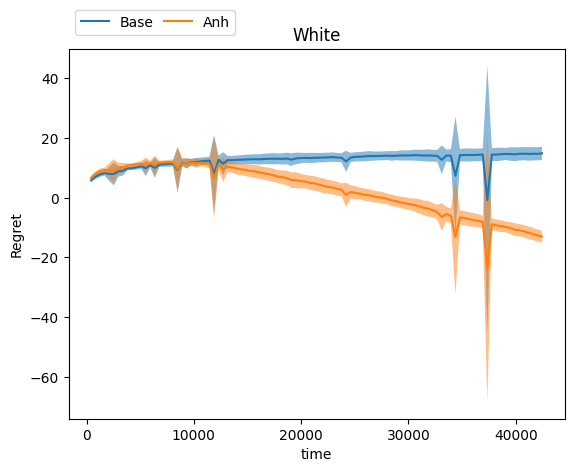

Asian-Pac-Islander 1519


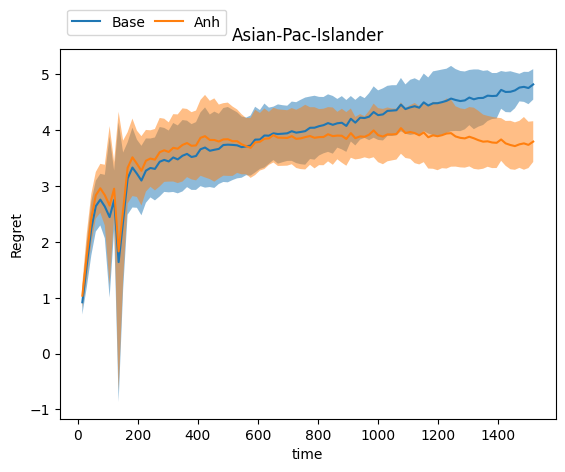

Amer-Indian-Eskimo 471


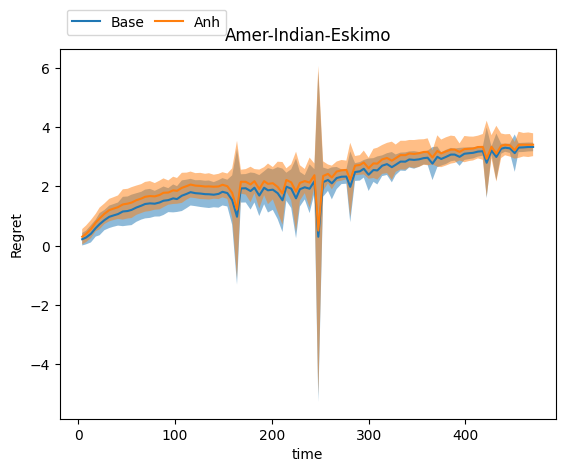

Other 406


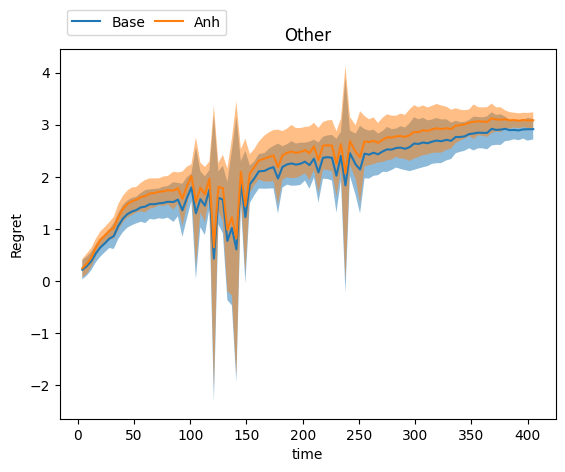

Black 4694


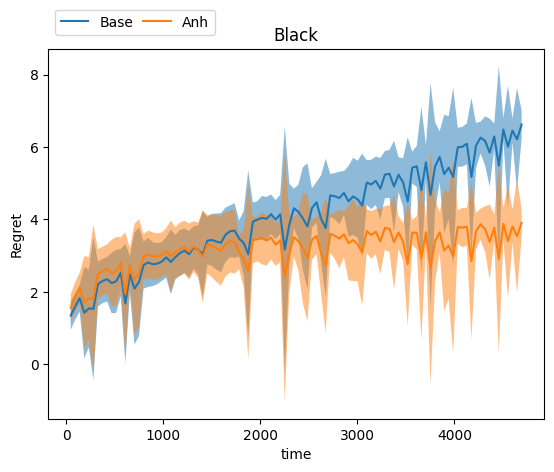

always_on 49531


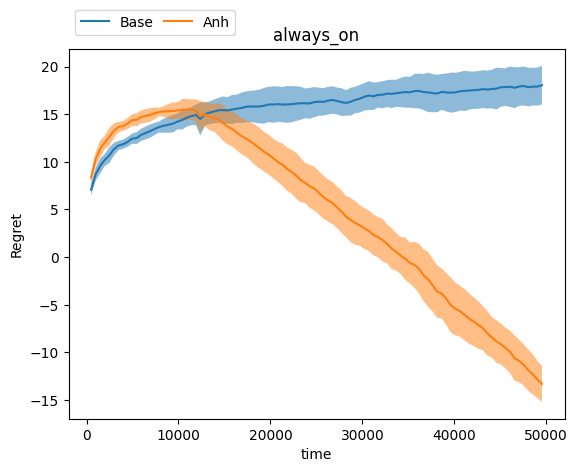

In [17]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std # with clipped y_vals of the least squares predictor
plot_regret_curve_with_std(ds_obj, 'adult_income_plots_exploss')

In [ ]:
# Testing best in hindsight vs ridge batch

In [10]:
performance_diff(ds_obj)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,450.168510,1.276885,428.277620,0.847336,21.890891,4.862821
middle,624.831559,1.705613,614.592733,1.611411,10.238826,1.638654
old,434.394247,1.149837,422.683228,1.412409,11.711019,2.695943
HighSchool&less,526.493605,1.094041,511.408555,1.089702,15.085050,2.865191
College&more,982.900711,1.998353,954.145025,1.724671,28.755686,2.925594
Male,1182.621030,2.315097,1149.271282,1.681161,33.349748,2.819986
Female,326.773286,0.503465,316.282298,0.891207,10.490988,3.210479
White,1326.996324,2.398741,1287.520499,2.090025,39.475825,2.974825
Asian-Pac-Islander,59.481154,0.288898,58.263756,0.465740,1.217398,2.046696
Amer-Indian-Eskimo,12.380835,0.144627,12.317055,0.236884,0.063779,0.515144


In [3]:
ds_obj = load_ob('adult_gw_expcloss.pkl')

In [10]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [6]:
performance_diff(ds_ob)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,450.168510,1.276885,428.277620,0.847336,21.890891,4.862821
middle,624.831559,1.705613,614.592733,1.611411,10.238826,1.638654
old,434.394247,1.149837,422.683228,1.412409,11.711019,2.695943
HighSchool&less,526.493605,1.094041,511.408555,1.089702,15.085050,2.865191
College&more,982.900711,1.998353,954.145025,1.724671,28.755686,2.925594
Male,1182.621030,2.315097,1149.271282,1.681161,33.349748,2.819986
Female,326.773286,0.503465,316.282298,0.891207,10.490988,3.210479
White,1326.996324,2.398741,1287.520499,2.090025,39.475825,2.974825
Asian-Pac-Islander,59.481154,0.288898,58.263756,0.465740,1.217398,2.046696
Amer-Indian-Eskimo,12.380835,0.144627,12.317055,0.236884,0.063779,0.515144


In [10]:
performance_diff(ds_obj) # with the group indicators for age and education added back in

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,448.107535,1.071989,428.381960,0.896057,19.725575,4.401974
middle,615.638923,1.279249,612.358934,1.318549,3.279990,0.532778
old,429.860031,0.934819,421.510438,1.139132,8.349592,1.942398
HighSchool&less,521.207401,1.303138,506.395120,0.598105,14.812281,2.841917
College&more,972.399088,1.954399,955.856211,1.942387,16.542877,1.701244
Male,1169.323624,2.217517,1147.757102,1.624030,21.566522,1.844359
Female,324.282865,0.516706,314.494230,0.860006,9.788635,3.018548
White,1313.031452,2.323663,1285.166634,2.094360,27.864819,2.122175
Asian-Pac-Islander,59.151892,0.269591,58.127823,0.370357,1.024069,1.731253
Amer-Indian-Eskimo,12.290018,0.151275,12.366185,0.405768,-0.076167,-0.619747


In [11]:
performance_diff(ds_obj) # with the group indicators for age and education added back in

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,448.107535,1.071989,428.381960,0.896057,19.725575,4.401974
middle,615.638923,1.279249,612.358934,1.318549,3.279990,0.532778
old,429.860031,0.934819,421.510438,1.139132,8.349592,1.942398
HighSchool&less,521.207401,1.303138,506.395120,0.598105,14.812281,2.841917
College&more,972.399088,1.954399,955.856211,1.942387,16.542877,1.701244
Male,1169.323624,2.217517,1147.757102,1.624030,21.566522,1.844359
Female,324.282865,0.516706,314.494230,0.860006,9.788635,3.018548
White,1313.031452,2.323663,1285.166634,2.094360,27.864819,2.122175
Asian-Pac-Islander,59.151892,0.269591,58.127823,0.370357,1.024069,1.731253
Amer-Indian-Eskimo,12.290018,0.151275,12.366185,0.405768,-0.076167,-0.619747


In [19]:
from bilevel.Groupwise_seedruns import get_end_regret_gw_df

df_regend_adult = get_end_regret_gw_df(ds_obj)

In [20]:
df_regend_adult

,group_name,group_size,mean_regend_Base,std_regend_Base,mean_regend_Anh,std_regend_Anh
0,young,22792,35.301100,1.023446,15.575525,0.857881
1,middle,16881,17.574860,1.199682,14.294870,1.243923
2,old,9858,23.371481,0.887885,15.021888,1.074001
3,HighSchool&less,22584,28.212828,1.239686,13.400547,0.566817
4,College&more,26947,24.945227,1.849952,8.402350,1.840241
5,Male,33174,19.207949,2.102350,-2.358573,1.541027
6,Female,16357,17.027720,0.490196,7.239085,0.810889
7,White,42441,14.846562,2.200426,-13.018257,1.980593
8,Asian-Pac-Islander,1519,4.820219,0.272803,3.796150,0.364525
9,Amer-Indian-Eskimo,471,3.333122,0.143891,3.409289,0.385778


In [21]:
df_regend_adult['mean_regend_Base'] - df_regend_adult['mean_regend_Anh']

0     19.725575
1      3.279990
2      8.349592
3     14.812281
4     16.542877
5     21.566522
6      9.788635
7     27.864819
8      1.024069
9     -0.076167
10    -0.169886
11     2.712322
12    31.355157
dtype: float64

In [22]:
df_regend_adult.to_csv('df_regend_adultincome.csv')